In [1]:
import numpy as np

from edgedroid.models.timings import *
import edgedroid.data as default_data

exec_time_data, neuroticism_data, imp_data, dur_data = default_data.load_default_exec_time_data()
exec_time_data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [2]:
data = preprocess_data(exec_time_data, neuroticism_data, imp_data, dur_data)
data

/Users/molguin/workspace/personal/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/personal/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/personal/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/personal/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise i

,run_id,ttf,next_exec_time,neuroticism,neuroticism_raw,impairment,duration,transition,duration_raw
0,134146,0.000000,3.654797,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,1
1,134146,0.597441,4.438645,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,2
2,134146,0.553513,2.943222,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,3
3,134146,0.561716,5.405761,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,4
4,134146,0.586512,5.225161,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[5.0, 10.0)",NoTransition,5
...,...,...,...,...,...,...,...,...,...
6755,137353,0.577341,6.439071,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,6
6756,137353,0.557074,4.680858,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,7
6757,137353,0.534339,3.467878,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,8
6758,137353,0.560288,2.325759,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,9


# Validation

For each `run_id`, we
1. Build a model excluding the data associated to that `run_id`.
2. Execute X runs of the model following the sequence of TTFs in the excluded run.
3. Collect the TTFs generated per step by the model.
4. Calculate error w.r.t. excluded `run_id`.


In [3]:
from collections import deque
import pandas as pd
from typing import Tuple

result_rows = deque()

for run_id in data["run_id"].unique():
    test_data = data[data["run_id"] == run_id].copy()
    
    def get_test_data(*args, **kwargs) -> Tuple[pd.DataFrame, pd.arrays.IntervalArray, pd.arrays.IntervalArray, pd.arrays.IntervalArray]:
        etime_data = exec_time_data[exec_time_data["run_id"] != run_id].copy()
        return etime_data, neuroticism_data, imp_data, dur_data
    
    class EmpiricalTestModel(EmpiricalETM):
        get_data = get_test_data
        
    class NaiveTestModel(FirstOrderETM):
        get_data = get_test_data
    
    neuroticism = test_data["neuroticism_raw"].unique()[0]
    empirical_model = EmpiricalTestModel(neuroticism=neuroticism)
    naive_model = NaiveTestModel()
    
    for _ in range(30):
        for i, (prev_ttf, exec_time) in enumerate(test_data[["ttf", "next_exec_time"]].itertuples(index=False)):
            if i != 0:
                # first row has no previous ttf
                empirical_model.advance(prev_ttf)
                naive_model.advance(prev_ttf)
                
            predicted_realistic_exec_time = empirical_model.get_execution_time()
            predicted_naive_exec_time = naive_model.get_execution_time()
            result_rows.append({
                "real": exec_time, 
                "prediction": predicted_realistic_exec_time, 
                "model": "realistic"
            })
            result_rows.append({
                "real": exec_time,
                "prediction": predicted_naive_exec_time,
                "model": "1st order"
            })
            
results = pd.DataFrame(result_rows)
results

,real,prediction,model
0,3.654797,3.207323,realistic
1,3.654797,4.604927,1st order
2,4.438645,3.129014,realistic
3,4.438645,6.853581,1st order
4,2.943222,4.429755,realistic
...,...,...,...
405595,3.467878,4.515085,1st order
405596,2.325759,2.491084,realistic
405597,2.325759,5.068921,1st order
405598,4.615283,6.550875,realistic


In [4]:
import numpy as np

results["error"] = results["prediction"] - results["real"]
results["sqr_error"] = np.square(results["error"])

results

,real,prediction,model,error,sqr_error
0,3.654797,3.207323,realistic,-0.447474,0.200233
1,3.654797,4.604927,1st order,0.950130,0.902746
2,4.438645,3.129014,realistic,-1.309630,1.715132
3,4.438645,6.853581,1st order,2.414936,5.831916
4,2.943222,4.429755,realistic,1.486533,2.209780
...,...,...,...,...,...
405595,3.467878,4.515085,1st order,1.047206,1.096641
405596,2.325759,2.491084,realistic,0.165325,0.027332
405597,2.325759,5.068921,1st order,2.743162,7.524937
405598,4.615283,6.550875,realistic,1.935592,3.746516


In [5]:
results.groupby("model").describe().drop(columns=["real", "prediction"]).T

model               1st order     realistic
error     count  2.028000e+05  2.028000e+05
          mean  -1.047071e-02  1.690105e-02
          std    4.487192e+00  4.505640e+00
          min   -5.353806e+01 -5.348104e+01
          25%   -2.190984e+00 -2.151808e+00
          50%   -7.356693e-03  1.425663e-02
          75%    2.176100e+00  2.171553e+00
          max    5.461729e+01  5.457249e+01
sqr_error count  2.028000e+05  2.028000e+05
          mean   2.013490e+01  2.030098e+01
          std    8.139330e+01  8.320450e+01
          min    2.553010e-09  2.312258e-09
          25%    1.024312e+00  9.914760e-01
          50%    4.770675e+00  4.673371e+00
          75%    1.546624e+01  1.534314e+01
          max    2.983049e+03  2.978156e+03

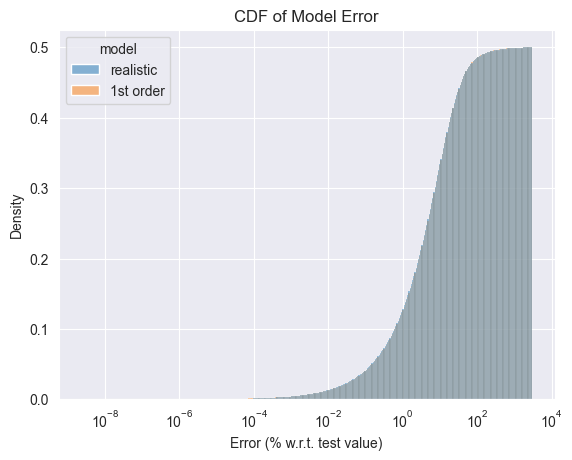

In [6]:
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.histplot(data=results, x="sqr_error", hue="model", stat="density", log_scale=True, cumulative=True)
ax.set_title("CDF of Model Error")
ax.set_xlabel("Error (% w.r.t. test value)")
plt.show()